# Week 5: Rossby waves
### MAQ - 32806, Chiel van Heerwaarden & Imme Benedict, 2016
In this assignment you will study the properties of Rossby waves. For this, you will a month of ECMWF ERA-Interim data from February 2015.
___
First, we load the required packages.

In [1]:
import numpy as np              # Numpy is the fundamental package for scientific computing in Python.
import netCDF4 as nc            # NetCDF is the data format of the meteorological data that we use.
import matplotlib.pyplot as pl  # Matplotlib is a scientific plotting package.
from mpl_toolkits.basemap import Basemap # Import the map plotting interface.
from ipywidgets import interact
import warnings
warnings.filterwarnings('ignore')

# The statement below enforces the plots to be put into this notebook, instead of in their own windows.
%matplotlib inline
pl.rcParams.update({'font.size': 11})          # Set the standard font size of the plots to 11pt.
pl.rcParams.update({'figure.figsize': [13,5]}) # Set the standard figure size.

___
### Setting up a Python Basemap and read out 3D fields
With the code below, you initialize the world map with the desired coordinates.

In [2]:
# We define a map of the northern hemisphere that is stored in the m object.
lon_start =  -180.
lon_end   =   180.
lat_start =     0.
lat_end   =    85.
m = Basemap(llcrnrlon=lon_start,
            llcrnrlat=lat_start,
            urcrnrlon=lon_end,
            urcrnrlat=lat_end,
            projection='mill', resolution='l')

___

Now, you load the data and read out the desired variables from a NetCDF file from the ECMWF ERA-Interim data archive.

In [3]:
nc_file = nc.Dataset("data/era_data2.nc", "r")
lat = nc_file.variables["latitude"][:]
lon = nc_file.variables["longitude"][:]

nroll = lon.size//2
lon = np.roll(lon, nroll)
lon = np.where(lon>=180., lon-360., lon)

u   = np.roll(nc_file.variables["u"][:,:,:], nroll, -1)
v   = np.roll(nc_file.variables["v"][:,:,:], nroll, -1)
Phi = np.roll(nc_file.variables["z"][:,:,:], nroll, -1)
T   = np.roll(nc_file.variables["t"][:,:,:], nroll, -1)

time = np.arange(0, 28, 0.25)

nc_file.close()

lons, lats = m(*np.meshgrid(lon, lat))

def get_lat_index(lat_plot):
    return abs(lat-lat_plot).argmin()

___
### 1. The time evolution of temperature, geopotential and meridional wind
As a starting point you find below the temperature and geopotential at 500 hPa. With the slider above the plot you can change the time. If you click on the slider, you can change the time with the left and right arrow keys.

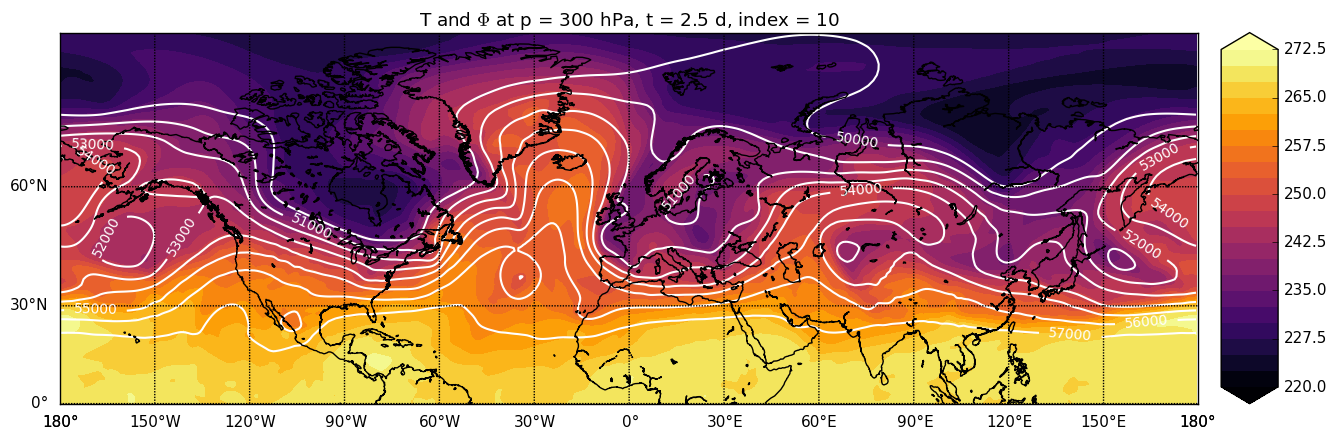

In [14]:
Phi_range = np.arange(50000, 100000, 1000)
T_range = np.arange(220, 275, 2.5)

def plot_T_map(t=2.5):
    nt = abs(time-t).argmin()

    pl.figure()
    m.contourf(lons, lats, T[nt,:,:], T_range, cmap=pl.cm.inferno, extend='both')
    m.colorbar()

    cz = m.contour(lons, lats, Phi[nt,:,:], Phi_range, colors='w', linewidths=1.5)
    pl.clabel(cz, fontsize=10., fmt='%1.0f')

    m.drawcoastlines(color='k')
    # draw parallels.
    parallels = np.arange(-90.,90,30.)
    m.drawparallels(parallels,labels=[1,0,0,0])
    # draw meridians
    meridians = np.arange(0.,360.,30.)
    m.drawmeridians(meridians,labels=[0,0,0,1])
    pl.title('T and $\Phi$ at p = 300 hPa, t = {0} d, index = {1}'.format(t, nt));
    pl.tight_layout()
    
interact(plot_T_map, t=(0, 28.75, 0.25));

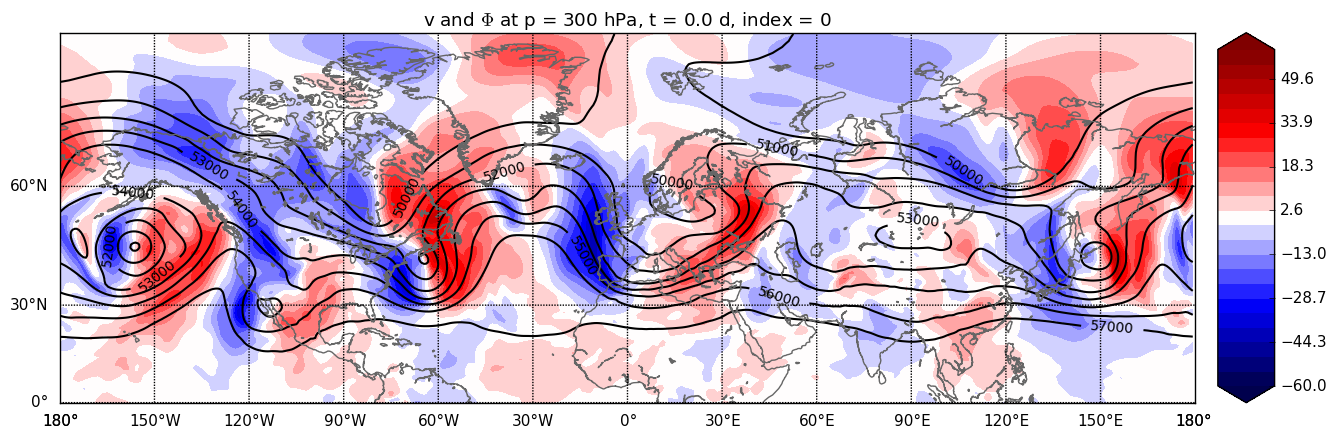

In [12]:
v_range = np.linspace(-60., 60., 24)

def plot_v_map(t=2.5):
    nt = abs(time-t).argmin()
    
    pl.figure()
    m.contourf(lons, lats, v[nt,:,:], v_range, cmap=pl.cm.seismic, extend='both')
    m.colorbar()

    cz = m.contour(lons, lats, Phi[nt,:,:], Phi_range, colors='k', linewidths=1.5)
    pl.clabel(cz, fontsize=10., fmt='%1.0f')

    m.drawcoastlines(color='#666666')
    # draw parallels.
    parallels = np.arange(-90.,90,30.)
    m.drawparallels(parallels,labels=[1,0,0,0])
    # draw meridians
    meridians = np.arange(0.,360.,30.)
    m.drawmeridians(meridians,labels=[0,0,0,1])
    pl.title('v and $\Phi$ at p = 300 hPa, t = {0} d, index = {1}'.format(t, nt));
    pl.tight_layout()

interact(plot_v_map, t=(0, 28.75, 0.25));

#### Questions
1. Analyze the time evolution of the geopotential and temperature. Can you recognize Rossby waves in the field? Which direction do they travel?
2. Which latitude is the approximate axis of the Rossby waves?
3. What do you observe around the Rocky Mountains at approximately 120 W? Can you link this observation with the conservation of shallow water (or Rossby) potential vorticity $\left( \zeta + f \right) / h$?
4. Which of the two signals is more dominated by smaller scale fluctuations, that of $\Phi$ or that of $v$? Why?
___

### 2. From signal to noise: averaging over a latitude band
To be able to analyze the wave behavior the best, you will average the data over a latitude band. Below you find a figure that contains a plot of the geopotential $\Phi$ and the meridional velocity $v$.

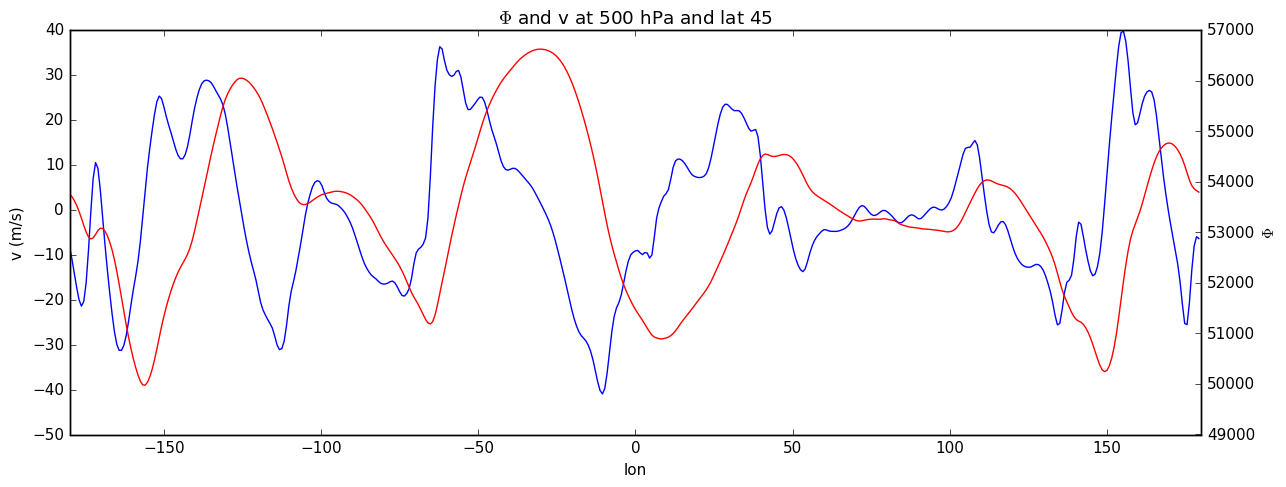

In [23]:
# Fill in below the latitude that you find most appropriate as the axis of the Rossby waves.
# Choose a time step that you consider to have a clear signal.
lat_axis = 45.
nt = 0

j_lat = get_lat_index(lat_axis)

pl.plot(lon, v[nt,j_lat,:], 'b-')
pl.xlabel('lon')
pl.ylabel('v (m/s)')
pl.twinx()
pl.plot(lon, Phi[nt,j_lat,:], 'r-')
pl.xlim(-180., 180)
pl.ylabel('$\Phi$')
pl.title('$\Phi$ and v at 500 hPa and lat {0:.0f}'.format(lat[j_lat]))
pl.tight_layout()

Now, you are going to replot this data, but with a smoothing over 15 degrees in order to contain the large part of the meridional extent of the Rossby wave in your line.

In [24]:
j_lat_lo = get_lat_index(lat_axis - 15.)+1
j_lat_hi = get_lat_index(lat_axis + 15.)

v_avg   = np.mean(v  [:,j_lat_hi:j_lat_lo,:], axis=1)
u_avg   = np.mean(u  [:,j_lat_hi:j_lat_lo,:], axis=1)
Phi_avg = np.mean(Phi[:,j_lat_hi:j_lat_lo,:], axis=1)

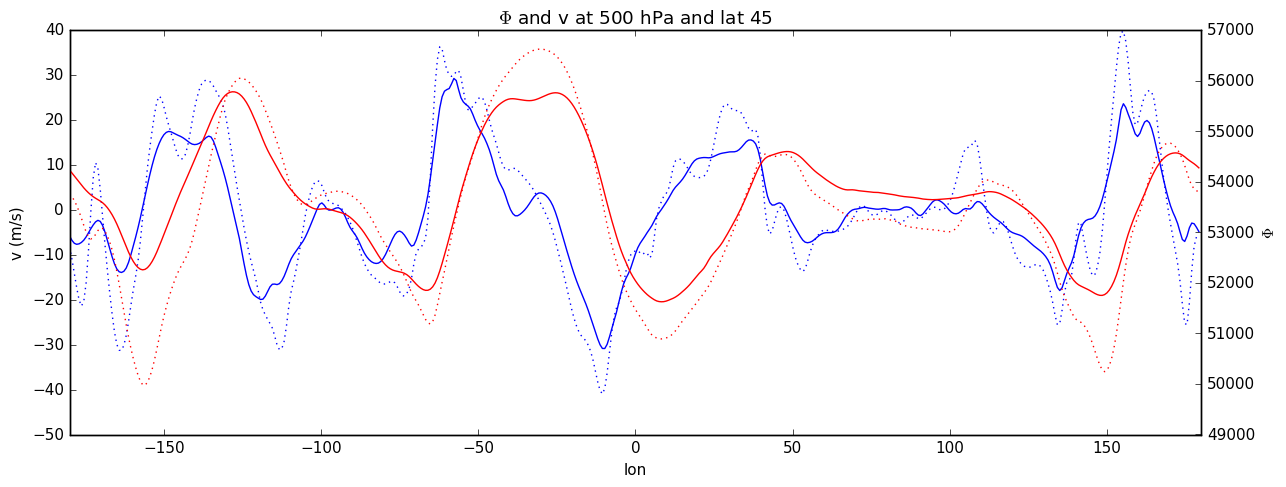

In [26]:
pl.plot(lon, v_avg[nt,:], 'b-')
pl.plot(lon, v[nt,j_lat,:], 'b:')
pl.xlabel('lon')
pl.ylabel('v (m/s)')
pl.twinx()
pl.plot(lon, Phi_avg[nt,:], 'r-')
pl.plot(lon, Phi[nt,j_lat,:], 'r:')
pl.xlim(-180., 180)
pl.ylabel('$\Phi$')
pl.title('$\Phi$ and v at 500 hPa and lat {0:.0f}'.format(lat[j_lat]))
pl.tight_layout()

1. Does the signal at your chosen latitude has has a clear wave pattern? Which wave numbers (you have to make a best guess here) dominate most to the signal? You can express the wave numbers in number of waves per earth circumference at your chosen latitude.
2. What remains of the pattern after averaging? What does that tell you about Rossby waves?
3. Are the time signals of $\Phi$ and $v$ in phase or out of phase? Can you explain that?
___

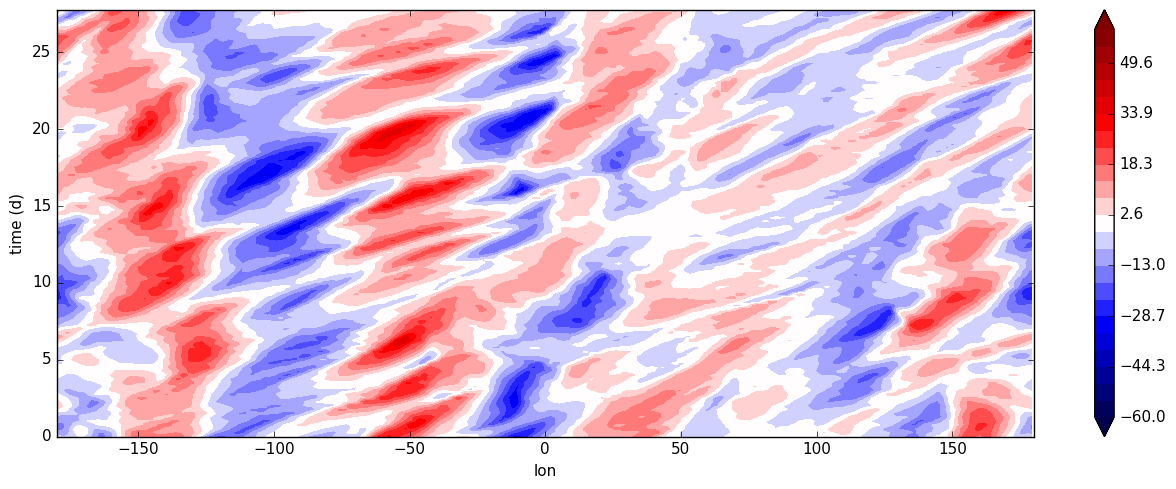

In [25]:
pl.figure()
pl.contourf(lon, time, v_avg, v_range, cmap=pl.cm.seismic, extend='both')
pl.colorbar()
pl.xlabel('lon')
pl.ylabel('time (d)')
pl.xlim(-180, 180)
pl.tight_layout()

In [10]:
v_fft = np.fft.rfft(v_avg, axis=1)
v_fft_energy = abs(v_fft / lon.size)**2
v_fft_energy[1:-1] *= 2.

Phi_fft = np.fft.rfft(Phi_avg, axis=1)
Phi_fft_energy = abs(Phi_fft / lon.size)**2
Phi_fft_energy[1:-1] *= 2.

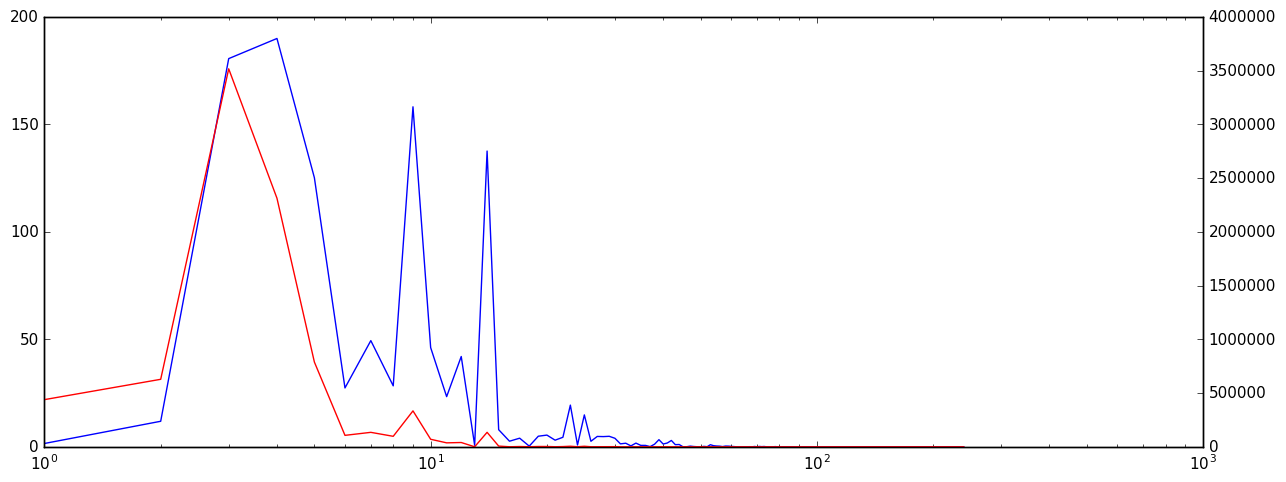

In [11]:
k = np.arange(lon.size/2+1)
pl.figure()
pl.semilogx(k, k*v_fft_energy[nt,:], 'b-');
pl.twinx()
pl.semilogx(k, k*Phi_fft_energy[nt,:], 'r-');
pl.tight_layout()

In [14]:
k_filter = np.zeros(v_fft.shape[1])
k_filter[0]    = 1.
#k_filter[1:7]  = 1.
k_filter[7:20] = 1.

v_fft_k = v_fft.copy() * k_filter[np.newaxis,:]
v_k = np.fft.irfft(v_fft_k, axis=1)

Phi_fft_k = Phi_fft.copy() * k_filter[np.newaxis,:]
Phi_k = np.fft.irfft(Phi_fft_k, axis=1)

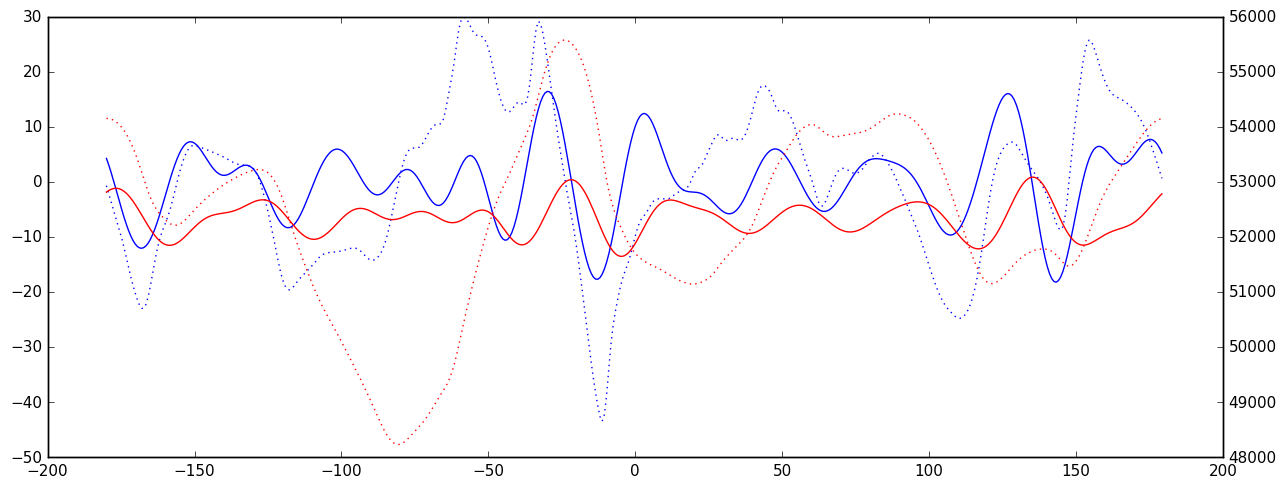

In [15]:
pl.figure()
pl.plot(lon, v_k[nt,:], 'b-')
pl.plot(lon, v_avg[nt,:], 'b:')
pl.twinx()
pl.plot(lon, Phi_k[nt,:], 'r-')
pl.plot(lon, Phi_avg[nt,:], 'r:')
pl.tight_layout()

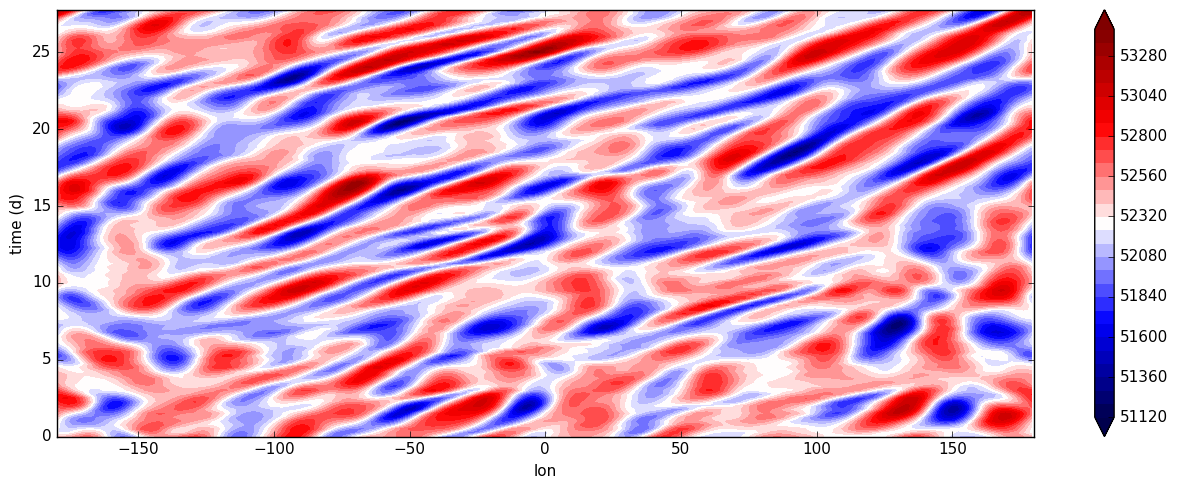

In [18]:
pl.figure()
pl.contourf(lon, time, v_k, v_range, cmap=pl.cm.seismic, extend='both')
pl.colorbar()
pl.xlabel('lon')
pl.ylabel('time (d)')
pl.xlim(-180, 180)
pl.tight_layout()